<a href="https://colab.research.google.com/github/Vaibhav67979/Ecommerce-product-recommendation-system/blob/main/Model_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

In [3]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/Data/Magazine data/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [4]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


### Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### Missing value analysis

In [6]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,0
rating,0


### Summary

In [7]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Rating distribution

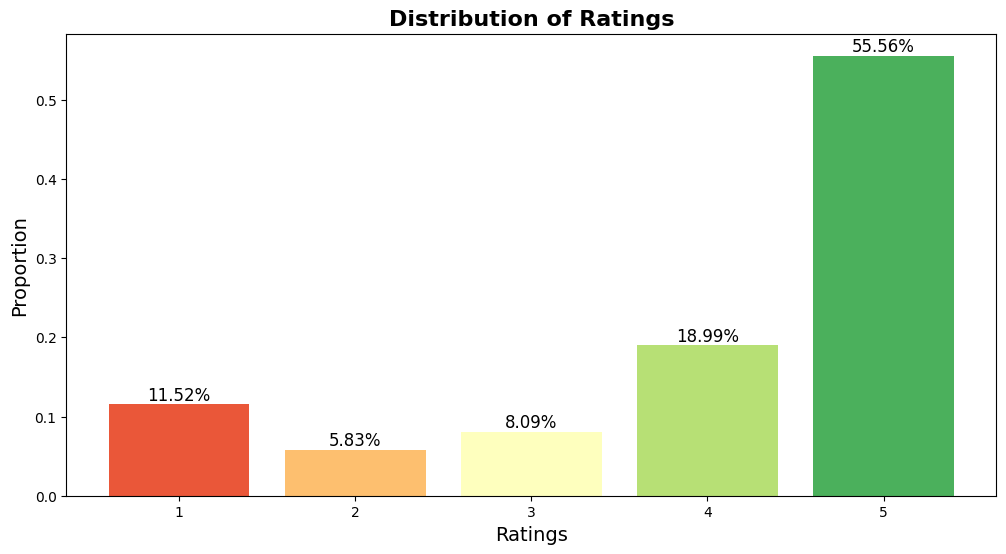

In [8]:
# Sort ratings in ascending order
rating_counts = df['rating'].value_counts(normalize=True).sort_index()

# Define colors using a gradient (from red to green)
colors = sns.color_palette("RdYlGn", len(rating_counts))

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(rating_counts.index, rating_counts.values, color=colors)

# Add percentage labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{bar.get_height():.2%}',
             ha='center', va='bottom', fontsize=12)

# Labels and title
plt.xlabel("Ratings", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title("Distribution of Ratings", fontsize=16, fontweight='bold')
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.savefig("ratings_distribution.png", dpi=300, bbox_inches='tight')
# Show
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [9]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### Users with most no of rating

In [10]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [11]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [12]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [13]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [14]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [15]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [16]:
U.shape

(1540, 50)

In [17]:
sigma.shape

(50, 50)

In [18]:
Vt.shape

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [19]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [20]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 100

In [21]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(100,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
11078    1.624746
16159    1.132730
10276    1.047888
22210    0.955049
18887    0.879705
Name: user_predictions, dtype: float64


### Recommending top 10 products to user id 90

In [22]:
recommend_items(90,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 90):

Recommended Products
11078    0.747400
38250    0.493052
15538    0.461014
10276    0.445387
39338    0.411386
33113    0.349688
38656    0.344499
22460    0.327589
18887    0.318683
5317     0.311928
Name: user_predictions, dtype: float64


## Evaluating the model

In [23]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
prod_id,
0594451647,0.003247
0594481813,0.001948
0970407998,0.003247
0972683275,0.012338
1400501466,0.012987


In [25]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [26]:
avg_preds=preds_df.mean()
avg_preds.head()

,0
prod_id,
0594451647,0.003360
0594481813,0.005729
0970407998,0.008566
0972683275,0.035330
1400501466,0.006966


In [27]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [28]:

import altair as alt
import pandas as pd

# Assuming 'rmse_df' is your dataframe

# Create the first chart for Actual ratings
chart1 = alt.Chart(rmse_df).mark_line(point=True).encode(
    x=alt.X('index', title="Data Points"),
    y=alt.Y('Avg_actual_ratings', title="Average Actual Ratings"),
    color=alt.value('blue'),  # Set color for actual ratings line
    tooltip=['index', 'Avg_actual_ratings']
).properties(
    title="Average Actual Ratings",
    width=800,  # 16:9 aspect ratio
    height=450
).interactive()

chart1


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

Try enabling the VegaFusion data transformer which raises this limit by pre-evaluating data
transformations in Python.
    >> import altair as alt
    >> alt.data_transformers.enable("vegafusion")

Or, see https://altair-viz.github.io/user_guide/large_datasets.html for additional information
on how to plot large datasets.

alt.Chart(...)

In [29]:
# Create the second chart for Predicted ratings
chart2 = alt.Chart(rmse_df).mark_line(point=True).encode(
    x=alt.X('index', title="Data Points"),
    y=alt.Y('Avg_predicted_ratings', title="Average Predicted Ratings"),
    color=alt.value('red'),  # Set color for predicted ratings line
    tooltip=['index', 'Avg_predicted_ratings']
).properties(
    title="Average Predicted Ratings",
    width=800,  # 16:9 aspect ratio
    height=450
).interactive()

chart2

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

Try enabling the VegaFusion data transformer which raises this limit by pre-evaluating data
transformations in Python.
    >> import altair as alt
    >> alt.data_transformers.enable("vegafusion")

Or, see https://altair-viz.github.io/user_guide/large_datasets.html for additional information
on how to plot large datasets.

alt.Chart(...)

In [30]:
MSE = mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'])
RMSE = MSE ** 0.5  # Taking square root manually
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.013679389779858008 

